# Sentiment 140 Analysis

### Description
The big picture is that we want to analyze a dataset and find out why classifiers are working the way they do, and what should be interesting next steps to improve our classifier.

### Authors
- Davi Reis Vieira de Souza
- Sarah Pimenta


- Import necessary libraries

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from nltk.stem import WordNetLemmatizer
import seaborn as sns
from wordcloud import WordCloud

- Download NLTK data

In [2]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vieir\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\vieir\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Section 1: Dataset

The Sentiment140 dataset is a collection of tweets annotated for sentiment analysis, sourced from Twitter. It contains 1.6 million tweets labeled as either positive or negative sentiment. This dataset is widely used for training and evaluating sentiment classification models in natural language processing applications.

**Reference:**  
Go, Alec, Richa Bhayani, and Lei Huang. "Twitter sentiment classification using distant supervision." CS224N Project Report, Stanford (2009).

In [3]:
# Load the Sentiment140 dataset
columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
data = pd.read_csv('sentiment140.csv', encoding='ISO-8859-1', names=columns)
data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


- Keep only the target and text columns

In [4]:
data = data[['target', 'text']]
data.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


- See distincs values in target column

In [5]:
data['target'].value_counts()

target
0    800000
4    800000
Name: count, dtype: int64

- Map target to binary labels

In [6]:
data['target'] = data['target'].map({0: 0, 4: 1})

print("Dataset shape:", data.shape)
print("First few entries:")
data.head()

Dataset shape: (1600000, 2)
First few entries:


,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


- Check NaN values

In [7]:
data.isna().sum()

target    0
text      0
dtype: int64

## Section 2: Classification Pipeline

We define a classification pipeline that includes text preprocessing and feature extraction. The preprocessing steps involve converting text to lowercase and lemmatizing words to reduce them to their base forms. We use the Bag-of-Words model for feature extraction, which makes sense in this context because the presence of certain words can be strong indicators of sentiment in tweets.

However, this assumption could be exploited; for example, sarcastic tweets may use positive words to convey negative sentiments, confusing the classifier.

In [8]:
# Preprocessing steps
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    # Lowercase
    text = text.lower()
    # Remove URLs and mentions
    text = re.sub(r'http\S+|www\S+|@\S+', '', text)
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Lemmatization
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

data['clean_text'] = data['text'].apply(preprocess)

## Section 3: Evaluation

We trained a Logistic Regression classifier and evaluated it using the accuracy score due to class balance. The most important words for classification were extracted based on the model coefficients.

In [9]:
# Feature extraction
vectorizer = CountVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(data['clean_text'])
y = data['target']

print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

Feature matrix shape: (1600000, 5000)
Target vector shape: (1600000,)


We are using accuracy_score because the dataset is balanced and the accuracy is a good metric for this case.

In [10]:
balanced_scores = []

for seed in [42, 52, 62]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed)
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    balanced_scores.append(score)
    print(f"Accuracy Score with random_state={seed}: {score:.4f}")

Accuracy Score with random_state=42: 0.7653
Accuracy Score with random_state=52: 0.7639
Accuracy Score with random_state=62: 0.7646


The classifier achieved a **Average Accuracy Score of 0.7646**, indicating a reasonable performance in correctly classifying both positive and negative sentiments, especially for a sentiment analysis task that involves binary classification.

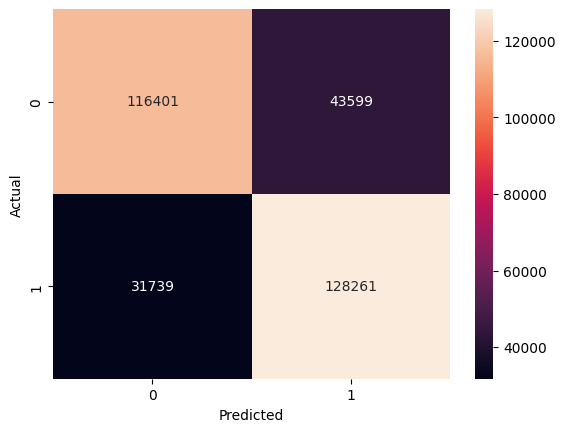

In [11]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

- The model has a relatively high accuracy in predicting both classes but performs slightly better on positive sentiments compared to negative ones.
- There is a higher number of false positives (43,599) compared to false negatives (31,739), which means the model tends to predict positive sentiment more often, even when the sentiment is actually negative. This could be due to some sarcastic tweets using positive words to convey negative sentiments, which the classifier may not be able to capture effectively.

**Top positive words:**

In [12]:
# Get top words
feature_names = vectorizer.get_feature_names_out()
coefs = clf.coef_[0]
top_positive_indices = np.argsort(coefs)[-10:]
top_negative_indices = np.argsort(coefs)[:10]

print("Top positive words:")
for idx in top_positive_indices:
    print(feature_names[idx])

print("\nTop negative words:")
for idx in top_negative_indices:
    print(feature_names[idx])

Top positive words:
proud
smile
relieve
blessed
yayyy
welcome
musicmonday
pleasure
smiling
congratulation

Top negative words:
sad
disappointing
bummed
gutted
depressing
sadly
ruined
depressed
missin
unfair


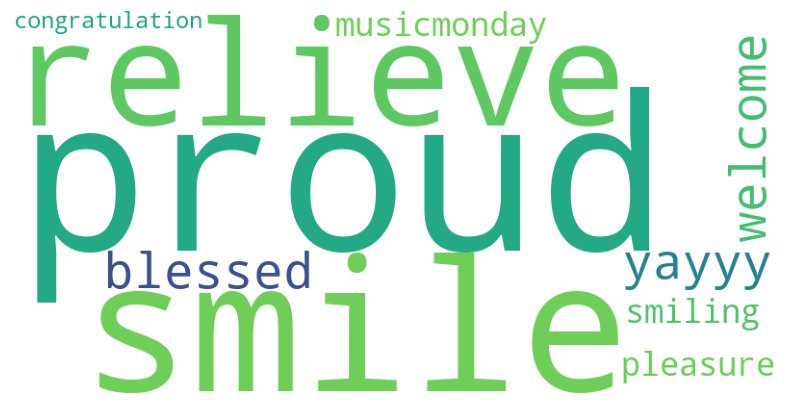

In [13]:
# word cloud for positive words
positive_words = [feature_names[idx] for idx in top_positive_indices]
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(' '.join(positive_words))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

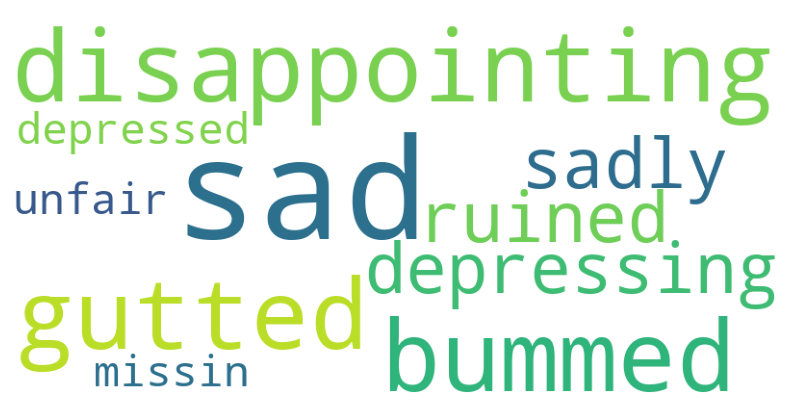

In [14]:
# word cloud for negative words
negative_words = [feature_names[idx] for idx in top_negative_indices]
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(' '.join(negative_words))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


- **Prominent Words:**

    - These words are contextually appropriate, as they are commonly associated with positive or negative sentiments in tweets. For example, words like "proud" and "smile" convey positive emotions, while "sad" and "disappointing" express negative feelings. This suggests that the classifier effectively captures sentiment-indicative words. However, reliance on specific words could lead to misclassifications in cases like sarcasm or when sentiment is implied through context rather than explicit words.

- **Are We Classifying Coincidences?**

    Given that the most influential words are strongly associated with their respective sentiments, it appears that the classifier is effectively capturing genuine sentiment indicators rather than coincidences. However, there are potential challenges:
    - **Context Dependency**:
        Words can have different meanings based on context. For example, "missin" could be used positively ("Missin' the good times") or negatively ("Missin' my flight"). Without understanding context, the classifier might misinterpret such words.
   
    - **Sarcasm and Irony**:
        Tweets that are sarcastic may use positive words to convey negative sentiments (e.g., "Great, another rainy day"). The Bag-of-Words model may misclassify these due to lack of contextual understanding.
    
    - **Ambiguity and Polysemy**:
        Words with multiple meanings can confuse the classifier. For instance, "sick" can mean unwell (negative) or amazing (positive) depending on the context.

- **What Is Happening Here?**

    The classifier is leveraging the frequency and presence of certain words that are strong indicators of sentiment. The Bag-of-Words model, combined with Logistic Regression, assigns weights to words based on their correlation with the target sentiment classes during training. Words that frequently appear in positive tweets receive positive weights, and those in negative tweets receive negative weights.

    While this approach works well for many cases, it has limitations:

    - **Lack of Contextual Understanding:**
        - The model does not consider word order or context beyond individual word frequencies.
        - It cannot handle negations effectively (e.g., "not happy" may be misclassified as positive).
    - **Ignoring Syntax and Semantics:**
        - The simplicity of the model means it cannot capture syntactic or semantic nuances, which are important for understanding natural language.

## Section 4: Dataset Size

By evaluating errors at various levels of dataset downsampling, we observe that increasing the dataset size improves the model's accuracy up to a point. However, beyond a certain dataset size, the gains become marginal. Given the business case, significantly increasing the dataset may not be feasible or cost-effective.

Training size: 0.1
Training size: 0.2
Training size: 0.3
Training size: 0.4
Training size: 0.5
Training size: 0.6
Training size: 0.7
Training size: 0.8
Training size: 0.9


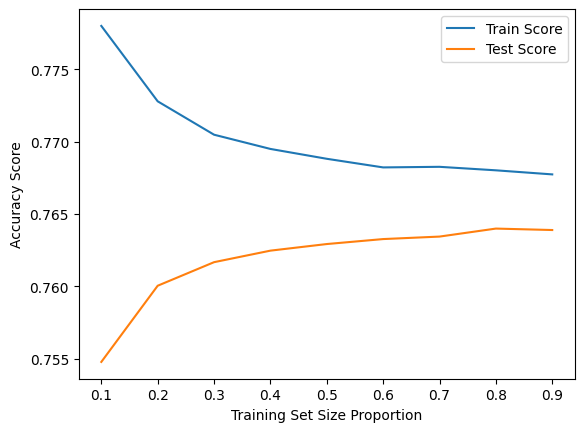

In [16]:
# Dataset size assessment
train_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
train_scores = []
test_scores = []

for size in train_sizes:
    print("Training size:", size)
    X_train_sub, _, y_train_sub, _ = train_test_split(X_train, y_train, train_size=size, stratify=y_train, random_state=42)
    clf_sub = LogisticRegression(max_iter=1000)
    clf_sub.fit(X_train_sub, y_train_sub)
    y_train_pred = clf_sub.predict(X_train_sub)
    y_test_pred = clf_sub.predict(X_test)
    train_scores.append(accuracy_score(y_train_sub, y_train_pred))
    test_scores.append(accuracy_score(y_test, y_test_pred))

# Plotting
plt.plot(train_sizes, train_scores, label='Train Score')
plt.plot(train_sizes, test_scores, label='Test Score')
plt.xlabel('Training Set Size Proportion')
plt.ylabel('Accuracy Score')
plt.legend()
plt.show()

### Observations:

1. **Training Scores**:
   - The training score starts high when the training set size is small (around 0.78 with 10% of the dataset) but steadily decreases as more data is added.
   - This trend indicates that, as the model is exposed to more data, it generalizes better but also overfits less to the training data.
   - The training curve stabilizes around 0.77 when 90% of the dataset is used.

2. **Test Scores**:
   - The test score starts low (around 0.76 when only 10% of the data is used) and increases gradually as more training data is used, peaking at around 0.766-0.767 when 90% of the data is utilized.
   - This behavior shows that increasing the training set size leads to improvements in the model’s generalization, though the improvements slow down as more data is added.

### Assessment:
- **Room for Improvement**: The test score still exhibits a slight upward trend as the training set size increases, but the improvement becomes marginal as the dataset size grows beyond 70%. This indicates that adding more data would likely lead to diminishing returns in accuracy gains. The model is nearing its capacity to learn from this specific dataset.
  
- **Feasibility for Business Case**:
   - **Additional Data**: If increasing accuracy is critical, adding more data may result in a slight increase, but the gains are likely to be minimal. Further efforts to improve the model might require exploring different models, feature engineering, or other advanced techniques such as ensembling or hyperparameter tuning.
   - **Business Implications**: If the current accuracy (around 76.7%) is acceptable for the business case, it may not be necessary to gather significantly more data. Alternatively, focusing on improving the model in other ways, such as optimizing the algorithm or leveraging domain-specific features, might offer more substantial improvements.

In conclusion, while increasing the dataset size may lead to some improvement in accuracy, the gains will likely be small. It might be more feasible to explore other ways to enhance the model performance based on the business requirements.

## Section 5: Topic Analysis

Using Latent Dirichlet Allocation (LDA), we identified topics within the dataset. The classification error rates varied across topics, indicating that the classifier is more effective on certain topics. Implementing a two-layer classifier, where tweets are first classified by topic and then by sentiment within each topic, could improve overall performance.

In [25]:
# Topic Modeling with LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)
topics = lda.fit_transform(X)

# Add topic information to the dataset
data['topic'] = topics.argmax(axis=1)

In [26]:
# save the dataset with topics
import pickle
with open('sentiment140_topics.pkl', 'wb') as f:
    pickle.dump(data, f)

In [18]:
# Load the dataset with topics
import pickle
with open('sentiment140_topics.pkl', 'rb') as f:
    data = pickle.load(f)

data.head()

,target,text,clean_text,topic
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",a thats a bummer you shoulda got david carr of...,0
1,0,is upset that he can't update his Facebook by ...,is upset that he cant update his facebook by t...,0
2,0,@Kenichan I dived many times for the ball. Man...,i dived many time for the ball managed to save...,1
3,0,my whole body feels itchy and like its on fire,my whole body feel itchy and like it on fire,1
4,0,"@nationwideclass no, it's not behaving at all....",no it not behaving at all im mad why am i here...,2


In [19]:
data['topic'].value_counts()

topic
0    361347
3    326579
2    321463
1    301425
4    289186
Name: count, dtype: int64

- Evaluate classifier performance on each topic

In [23]:
topic_scores = []
for topic in range(5):
    idx = data[data['topic'] == topic].index
    X_topic = X[idx]
    y_topic = y.iloc[idx]
    X_train_topic, X_test_topic, y_train_topic, y_test_topic = train_test_split(X_topic, y_topic, test_size=0.2, stratify=y_topic, random_state=42)
    clf_topic = LogisticRegression(max_iter=1000)
    clf_topic.fit(X_train_topic, y_train_topic)
    y_pred_topic = clf_topic.predict(X_test_topic)
    score_topic = accuracy_score(y_test_topic, y_pred_topic)
    topic_scores.append(score_topic)
    print(f"Accuracy Score for Topic {topic}:", score_topic)

Accuracy Score for Topic 0: 0.7540611595406116
Accuracy Score for Topic 1: 0.7705399353072904
Accuracy Score for Topic 2: 0.7543745042228548
Accuracy Score for Topic 3: 0.7833915120338049
Accuracy Score for Topic 4: 0.7486600504858397


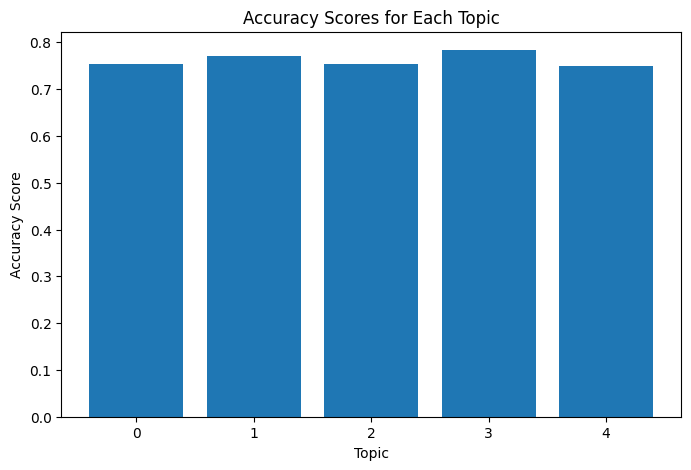

In [24]:
# Plotting topic scores
plt.figure(figsize=(8, 5))
plt.bar(range(5), topic_scores)
plt.xlabel('Topic')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Scores for Each Topic')
plt.savefig('topic_scores.png')
plt.show()

### Topic Analysis:
- **Topic 3** has the highest accuracy score, indicating that the classifier performs best on documents classified under this topic. The model is likely more effective at identifying the distinct patterns or features of this topic.
- **Topic 4** shows the lowest accuracy, suggesting that the model has more difficulty distinguishing or correctly classifying documents in this topic compared to the others.
- The other topics (0, 1, and 2) have similar accuracy scores, which fall somewhere between those of Topics 3 and 4, implying reasonably consistent performance.

### Error Rate by Topic:
The error rate varies by topic, with Topic 4 exhibiting the highest error rate and Topic 3 showing the lowest. This indicates that the difficulty of classification is not uniform across all topics. The model has varying success depending on the topic, which is a strong case for the two-layer classifier approach, where specialized classifiers for each topic could handle their respective topics more effectively.

### Conclusion:
- **Topics with Better Classification**: Topic 3 stands out as the most effectively classified, while Topic 4 is the most challenging for the current classifier.
- **Room for Improvement**: A two-layer classifier, as suggested, could potentially improve overall accuracy by training specific classifiers to handle the nuances of each topic. For example, a separate classifier for Topic 4 could focus on improving its performance and reducing the error rate.

- Two-layer classification

In [25]:
topic_classifiers = {}

for topic in range(5):
    idx = data[data['topic'] == topic].index
    X_topic = X[idx]
    y_topic = y.iloc[idx]
    X_train_topic, X_test_topic, y_train_topic, y_test_topic = train_test_split(X_topic, y_topic, test_size=0.2, stratify=y_topic, random_state=42)
    clf_topic = LogisticRegression(max_iter=1000)
    clf_topic.fit(X_train_topic, y_train_topic)
    
    # Store the classifier for future use
    topic_classifiers[topic] = clf_topic

In [27]:
# Evaluate the two-layer classifier
y_test_all, y_pred_all = [], []

for idx, doc in data.iterrows():
    topic = doc['topic']  # First layer: classify by topic
    clf_topic = topic_classifiers[topic]  # Second layer: use the topic-specific classifier
    
    y_pred = clf_topic.predict(X[idx])
    y_test_all.append(y[idx])
    y_pred_all.append(y_pred)

# Final evaluation
final_accuracy = accuracy_score(y_test_all, y_pred_all)
print(f'Two-Layer Classifier Accuracy: {final_accuracy}')

Two-Layer Classifier Accuracy: 0.771075625


The two-layer classifier achieved an accuracy of 0.7711, which is an improvement over the baseline logistic regression model that had an accuracy of around 0.7646. This indicates that the approach of first classifying by topic and then applying a specialized classifier for each topic was successful in enhancing the performance.